In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../Fields/DataAnalysis'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot
from numpy import linspace, abs as npabs, exp, sqrt, pi, asarray
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual

pyplot.rcParams['figure.figsize'] = [18, 9]
pyplot.rcParams['figure.dpi'] = 100

In [2]:
import open_sim

dataLocation = "/home/joao/Data/workdir/1d/testes/NiceData/"

simData = open_sim.OpenSimData(dataLocation + "radiation.osc")

## Total energy in time

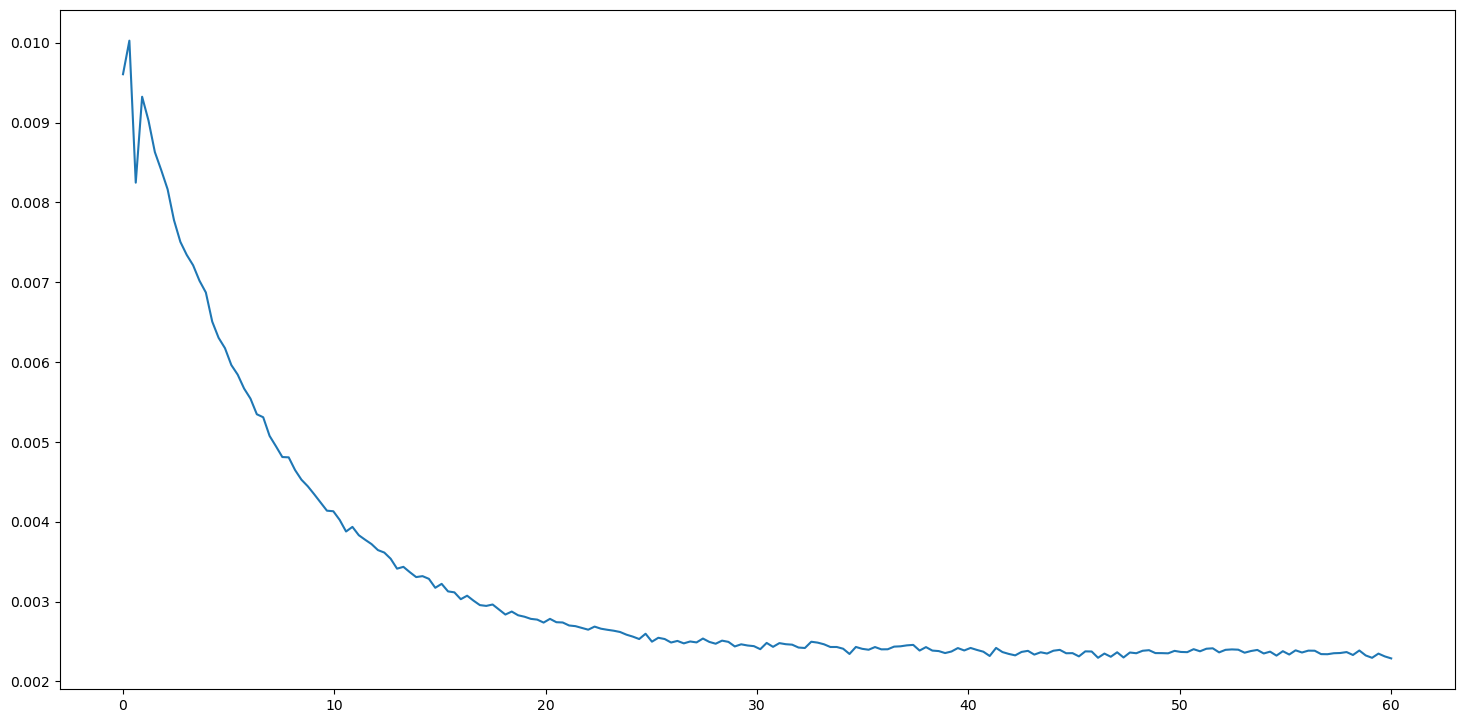

In [3]:
t=linspace(0, 60, 200)
E = []

for t_ in t:
    E.append(simData.getTotalEnergy(t_))

E = asarray(E)

pyplot.plot(t, E)

# Full data energy

Using cmap 'afmhot_r'


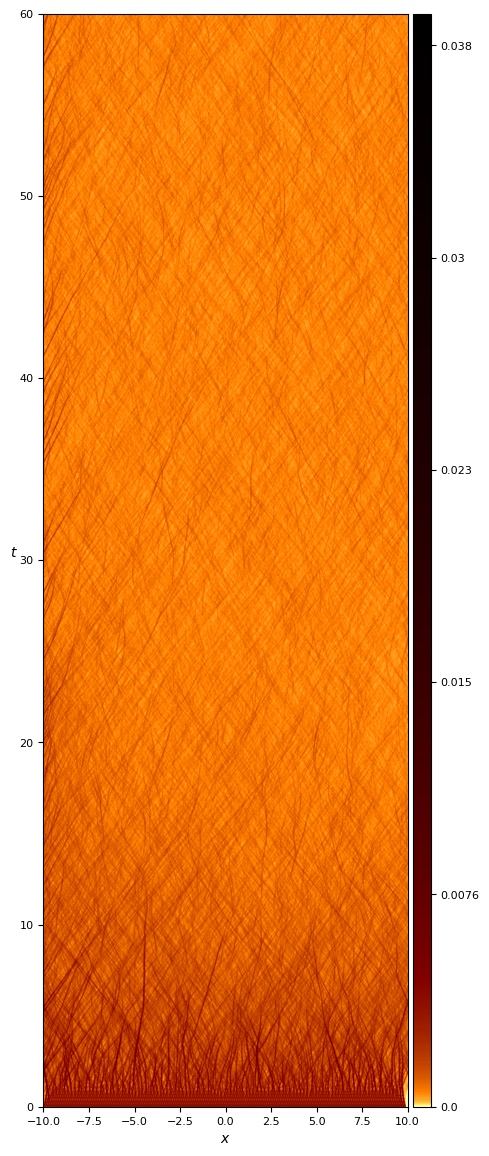

In [4]:
import plot_single

simDataPlot = plot_single.plot(simData, closeAfterUse=False, saveToFile=False, showEnergyDens=True, show_colorbar=True)

In [5]:
np.max(simData['phi'])

0.004633809715504058

# Statistical properties

In [6]:
from importlib import reload

if plot_single is not None:
    plot_single = reload(plot_single)
    
if open_sim is not None:
    open_sim = reload(open_sim)

In [7]:
t = simData['t']
x0, x1= -7.5, 7.5
K = simData.getKineticEnergyDensityInInterval(t, x0, x1)
KG = simData.getKineticAndGradientEnergyDensityInInterval(t, x0, x1)

## Temperatura

In [8]:
T=2*np.average(K)
print("T =",T)

T = 0.000113498500250547


## Distribuicoes

In [15]:

tmax = 60.0


@interact(t=(0.0, tmax), bin_count=(10,1000,1))
def plotEFreqDens(t, bin_count=400):
    #E = simData.getEnergyDensityInterval(t, x0, x1)
    #KD = simData.getKineticAndGradientEnergyDensityInInterval(t, x0, x1)
    #K = simData.getKineticEnergyDensityInInterval(t, x0, x1)
    #D = simData.getGradientEnergyDensityInInterval(t, x0, x1)
    V = np.abs(simData.getInstant(t, x0, x1))
    
    f = V
    
    bins = linspace(0, 10.e-4, bin_count)
    #pyplot.hist((K,D), bins, density=True, stacked=True)
    pyplot.hist(f, bins, density=True, stacked=True, histtype='stepfilled')
    
    pyplot.title('DOS for {} samples'.format(len(f)))
    pyplot.xlabel("$V(\\phi)$")
    pyplot.ylabel("n(E)")  
    
    pyplot.ylim(0, 2.1e4)

interactive(children=(FloatSlider(value=30.0, description='t', max=60.0), IntSlider(value=400, description='bi…

In [10]:
@interact(t=(0.0, tmax), bin_count=(10,1000,1))
def plotKFreqDens(t, bin_count=200):
    K = simData.getKineticEnergyDensityInInterval(t, x0, x1)

    bins = linspace(0, 10.e-4, bin_count)
    pyplot.hist(K, bins, density=True)

interactive(children=(FloatSlider(value=30.0, description='t', max=60.0), IntSlider(value=200, description='bi…

In [11]:
x = linspace(-1.e-1, 1.e-1, 200)
    
@interact(t=(0.0, tmax), T=(0.05, 0.15, 0.001))
def plotAvV(t, T=T*1.e3):
    v = simData.getTimeDerivativeInterval(t, x0, x1)
    
    vBins = linspace(-1.e-1, 1.e-1, 200)
    pyplot.hist(v, vBins, density=True)
    
    T*=1.e-3
    y = (1./(sqrt(2*pi*T)))*exp(-x*x/(2*T))
    pyplot.plot(x, y, label="Maxwell distr. of speeds")
    
    pyplot.text(-0.075, 30, "T={}".format(T))
    
    pyplot.xlabel("$\dot\phi$")
    pyplot.ylabel("$f(\dot\phi)$")
    
    pyplot.legend()



interactive(children=(FloatSlider(value=30.0, description='t', max=60.0), FloatSlider(value=0.113498500250547,…

In [12]:
def ComputeFunctionDistribution(function, begin_line: int, n_time_samples: int, bin_count: int, E_max: float):
    histogramAvg = 0
    bins=None
    
    for currLine in range(begin_line, begin_line+n_time_samples):
        E = function(currLine)
        histogram, bins=np.histogram(E, bin_count, density=False, range=(0,E_max))
        
        histogramAvg += np.asarray(histogram, dtype=np.float32)
    
    histogramAvg /= (len(E)*n_time_samples*(E_max/bin_count))
        
    return bins[:-1], histogramAvg

In [13]:
tmax = 60.0

@interact(t=(0.1, tmax), bin_count=(10,1000,1), width=(1,20,0.25), avg_samples=(1,500,1))
def plotEFreqDens(t, bin_count=150, width=12.5, avg_samples=50, density=False):
    
    line = simData._getLineForTime(t)
    
    E_max = 1.e-3
    
    func = lambda l: simData.getEnergyDensityIntervalIndexedTime(l, -width/2, width/2)
    
    bins, normalized_distr = ComputeFunctionDistribution(func, begin_line=line-avg_samples, n_time_samples=avg_samples, bin_count=bin_count,
                                          E_max=1.e-3)
        
    pyplot.plot(bins, normalized_distr)
    
    y_max=1.2e4
    
    E_avg=0
    for currLine in range(line-avg_samples, line):
        E_avg += np.average(func(currLine))
    E_avg /= avg_samples
    
    pyplot.plot((E_avg, E_avg), (0, y_max))
    
    pyplot.ylim(0, y_max)
    
    
    pyplot.title('DOS for {} samples'.format(len(E)*avg_samples))
    pyplot.xlabel("E")
    pyplot.ylabel("n(E)/N(E)")  

interactive(children=(FloatSlider(value=30.05, description='t', max=60.0, min=0.1), IntSlider(value=150, descr…

In [14]:
t=35.0
bin_count=150
width=12.5
avg_samples=50

func = lambda l: simData.getEnergyDensityIntervalIndexedTime(l, -width/2, width/2)

t_integer = simData._getLineForTime(t)
bins, normalized_distr = ComputeFunctionDistribution(func, begin_line=t_integer-avg_samples, n_time_samples=avg_samples, bin_count=bin_count, E_max=1.e-3)

np.average(func(t_integer))

0.00011840311604574311

In [16]:
x = linspace(-1.e-1, 1.e-1, 200)

@interact(t=(0.0, tmax), T=(0.05, 0.15, 0.001))
def plotAvV(t, T=T*1.e3):
    func = simData.getTimeDerivativeInterval(t, x0, x1)
    
    vBins = linspace(-1.e-1, 1.e-1, 200)
    pyplot.hist(v, vBins, density=True)
    
    T*=1.e-3
    y = (1./(sqrt(2*pi*T)))*exp(-x*x/(2*T))
    pyplot.plot(x, y, label="Maxwell distr. of speeds")
    
    pyplot.text(-0.075, 30, "T={}".format(T))
    
    pyplot.xlabel("$\dot\phi$")
    pyplot.ylabel("$f(\dot\phi)$")
    
    pyplot.legend()
    
tmax = 60.0

@interact(t=(0.1, tmax), bin_count=(10,1000,1), width=(1,20,0.25), avg_samples=(1,500,1))
def plotEFreqDens(t, bin_count=150, width=12.5, avg_samples=50, density=False):
    
    line = simData._getLineForTime(t)
    
    E_max = 1.e-3
    
    func = lambda l: simData.getEnergyDensityIntervalIndexedTime(l, -width/2, width/2)
    
    bins, normalized_distr = ComputeFunctionDistribution(func, begin_line=line-avg_samples, n_time_samples=avg_samples, bin_count=bin_count,
                                          E_max=1.e-3)
        
    pyplot.plot(bins, normalized_distr)
    
    y_max=1.2e4
    
    E_avg=0
    for currLine in range(line-avg_samples, line):
        E_avg += np.average(func(currLine))
    E_avg /= avg_samples
    
    pyplot.plot((E_avg, E_avg), (0, y_max))
    
    pyplot.ylim(0, y_max)
    
    
    pyplot.title('DOS for {} samples'.format(len(E)*avg_samples))
    pyplot.xlabel("E")
    pyplot.ylabel("n(E)/N(E)")

interactive(children=(FloatSlider(value=30.0, description='t', max=60.0), FloatSlider(value=0.113498500250547,…

In [ ]:
tmax = 60.0

@interact(t=(0.1, tmax), bin_count=(10,1000,1), width=(1,20,0.25), avg_samples=(1,500,1))
def plotEFreqDens(t, bin_count=150, width=12.5, avg_samples=50, density=False):
    
    line = simData._getLineForTime(t)
    
    E_max = 1.e-3
    
    func = lambda l: simData.getEnergyDensityIntervalIndexedTime(l, -width/2, width/2)
    
    bins, normalized_distr = ComputeFunctionDistribution(func, begin_line=line-avg_samples, n_time_samples=avg_samples, bin_count=bin_count,
                                          E_max=1.e-3)
        
    pyplot.plot(bins, normalized_distr)
    
    y_max=1.2e4
    
    E_avg=0
    for currLine in range(line-avg_samples, line):
        E_avg += np.average(func(currLine))
    E_avg /= avg_samples
    
    pyplot.plot((E_avg, E_avg), (0, y_max))
    
    pyplot.ylim(0, y_max)
    
    
    pyplot.title('DOS for {} samples'.format(len(E)*avg_samples))
    pyplot.xlabel("E")
    pyplot.ylabel("n(E)/N(E)")